# 第15章 样例类和模式匹配

本章将介绍样例类（case class）和模式匹配（pattern matching），这组孪生的语法结构为我们编写规则的、未封装的数据结构提供支持。这两个语法结构对于表达树形的递归数据尤其有用。

如果你之前曾用过函数式语言编程，你也许已经知道什么是模式匹配，不过样例类对你来说是新的概念。**样例类是Scala用来对对象进行模式匹配而并不需要大量的样板代码的方式**。笼统地说，你要做的就是对那些你希望能做模式匹配的类加上一个case关键字。

本章将从一个简单的样例类和模式匹配的例子开始。然后依次介绍Scala支持的各种模式，探讨密封类（sealed class），讨论Option类型，并展示语言中某些不那么明显地使用到模式匹配的地方。

In [1]:
object Element {
  private class ArrayElement(
    val contents: Array[String]
  ) extends Element

  private class LineElement(s: String) extends Element {
    val contents = Array(s)
    override def width = s.length
    override def height = 1
  }
  private class UniformElement(
    ch: Char,
    override val width: Int,
    override val height: Int
  ) extends Element {
    private val line = ch.toString * width
    def contents = Array.fill(height)(line)
  }

  def elem(contents:  Array[String]): Element =
    new ArrayElement(contents)
    
  def elem(chr: Char, width: Int, height: Int): Element =
    new UniformElement(chr, width, height)

  def elem(line: String): Element =
    new LineElement(line)
}

import Element.elem

abstract class Element {
  def contents:  Array[String]

  def width: Int = contents(0).length
  def height: Int = contents.length

  def above(that: Element): Element = {
    val this1 = this widen that.width
    val that1 = that widen this.width
    elem(this1.contents ++ that1.contents)
  }

  def beside(that: Element): Element = {
    val this1 = this heighten that.height
    val that1 = that heighten this.height
    elem(
      for ((line1, line2) <- this1.contents zip that1.contents) 
      yield line1 + line2)
  }

  def widen(w: Int): Element = 
    if (w <= width) this
    else {
      val left = elem(' ', (w - width) / 2, height) 
      var right = elem(' ', w - width - left.width, height)
      left beside this beside right
    }

  def heighten(h: Int): Element = 
    if (h <= height) this
    else {
      val top = elem(' ', width, (h - height) / 2)
      var bot = elem(' ', width, h - height - top.height)
      top above this above bot
    }

  override def toString = contents mkString "\n"
}

defined object Element
import Element.elem


defined class Element

## 15.1 一个简单的例子

在深入探讨模式匹配的所有规则和细节之前，有必要先看一个简单的例子，好让我们明白模式匹配大概是做什么的。假定你需要编写一个操作算术表达式的类库，可能这个类库是你正在设计的某个领域特性语言（DSL）的一部分。

解决这个问题的第一步是定义输入数据。为保持简单，我们将注意力集中在由变量、数，以及一元和二元操作符组成的算术表达式上。用Scala的类层次结构来表达，如示例15.1所示。

In [2]:
interp.configureCompiler(_.settings.nowarnings.value = false)

In [3]:
abstract class Expr
case class Var(name: String) extends Expr
case class Number(num: Double) extends Expr
case class UnOp(operator: String, arg: Expr) extends Expr
case class BinOp(operator: String, left: Expr, right: Expr) extends Expr

defined class Expr
defined class Var
defined class Number
defined class UnOp
defined class BinOp

这个层次结构包括一个抽象的基类Expr和四个子类，每一个都表示我们要考虑的一种表达式。[1]所有五个类的定义体都是空的。如之前提到的那样，Scala允许我们省去空定义体的花括号，即class C跟class C{}是相同的。

样例类

示例15.1中另一个值得注意的点是每个子类都有一个case修饰符。带有这种修饰符的类称作样例类（case class）。用上这个修饰符会让Scala编译器对我们的类添加一些语法上的便利。

**首先，它会添加一个跟类同名的工厂方法**。这意味着我们可以用Var（“x”）来构造一个Var对象，而不用稍长版本的new Var（“x”）：

In [4]:
val v = Var("x")

v: Var = Var("x")

当你需要嵌套定义时，工厂方法尤为有用。由于代码中不再到处落满new关键字，可以一眼就看明白表达式的结构：

In [5]:
val op = BinOp("+", Number(1), v)

op: BinOp = BinOp("+", Number(1.0), Var("x"))

其次，第二个语法上的便利是**参数列表中的参数都隐式地获得了一个val前缀，因此它们会被当作字段处理**：

In [6]:
v.name

res5: String = "x"

In [7]:
op.left

res6: Expr = Number(1.0)

再次，编译器会帮我们以“自然”的方式实现toString、hashCode和equals方法。这些方法分别会打印、哈希、比较包含类及所有入参的整棵树。由于Scala的==总是代理给equals方法，这意味着**以样例类表示的元素总是以结构化的方式做比较**：

In [8]:
println(op)

BinOp(+,Number(1.0),Var(x))


In [9]:
op.right == Var("x")

res8: Boolean = true

最后，编译器还会添加一个copy方法用于制作修改过的拷贝。这个方法可以用于制作除了一两个属性不同之外其余完全相同的该类的新实例。这个方法用到了带名字的参数和缺省参数（参考8.8节）。我们用带名字的参数给出想要做的修改。对于任何你没有给出的参数，都会用老对象中的原值。例如下面这段制作一个跟 op一样不过操作符改变了的操作的代码：

In [10]:
op.copy(operator = "-")

res9: BinOp = BinOp("-", Number(1.0), Var("x"))

所有这些带来的是大量的便利（代价却很小）。你需要多写一个case修饰符，并且你的类和对象会变得大那么一点。之所以更大，是因为生成了额外的方法，并且对于构造方法的每个参数都隐式地添加了字段。不过，样例类最大的好处是它们支持模式匹配。

**模式匹配**

假定我们想简化前面展示的算术表达式。可用的简化规则非常多，以下只列举一部分：
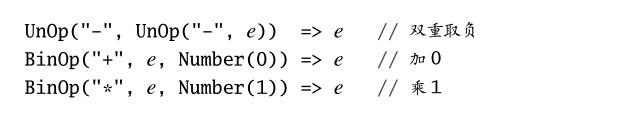
用模式匹配的话，这些规则可以被看成是一个Scala编写的简化函数的核心逻辑，如示例15.2所示。我们可以这样来使用这个simplifyTop函数：

In [11]:
def simplifyTop(expr: Expr): Expr = expr match {
    case UnOp("-", UnOp("-", e))  => e   // Double negation
    case BinOp("+", e, Number(0)) => e   // Adding zero
    case BinOp("*", e, Number(1)) => e   // Multiplying by one
    case _ => expr
}

defined function simplifyTop

In [12]:
simplifyTop(UnOp("-", UnOp("-", Var("x"))))

res11: Expr = Var("x")

In [13]:
simplifyTop(BinOp("+", Var("x1"), Number(0)))

res12: Expr = Var("x1")

In [14]:
simplifyTop(BinOp("*", Var("x2"), Number(1)))

res13: Expr = Var("x2")

In [15]:
simplifyTop(UnOp("-", Var("x")))

res14: Expr = UnOp("-", Var("x"))

In [16]:
simplifyTop(Number(2))

res15: Expr = Number(2.0)

simplifyTop的右边由一个match表达式组成。match表达式对应Java的switch，不过match关键字出现在选择器表达式后面。换句话说，写成：
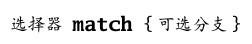
而不是：
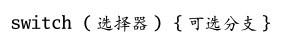
模式匹配包含一系列以case关键字打头的可选分支（alternative）。每一个可选分支都包括一个模式（pattern）以及一个或多个表达式，如果模式匹配了，这些表达式就会被求值。箭头符=>用于将模式和表达式分开。

一个match表达式的求值过程是按照模式给出的顺序逐一尝试的。第一个匹配上的模式被选中，跟在这个模式后面的表达式被执行。

类似＂+＂和1这样的常量模式（constant pattern）可以匹配那些按照==的要求跟它们相等的值。而像e这样的变量模式（variable pattern）可以匹配任何值。匹配后，在右侧的表达式中，这个变量将指向这个匹配的值。在本例中，注意前三个可选分支都求值为e，一个在对应的模式中绑定的变量。通配模式（wildcard pattern），即_也匹配任何值，不过它并不会引入一个变量名来指向这个值。在示例15.2中，注意match是以一个缺省的什么都不做的case结尾的，这个缺省的case直接返回用于匹配的表达式expr。

构造方法模式（constructor pattern）看上去就像UnOp（＂-＂, e）。这个模式匹配所有类型为UnOp且首个入参匹配＂-＂而第二个入参匹配e的值。注意构造方法的入参本身也是模式。这允许我们用精简的表示法来编写有深度的模式。例如：
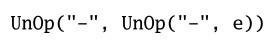
想象一下如果用访问者模式来实现相同的功能要怎么做！[2]再想象一下如果用一长串if语句、类型测试和类型转换来实现相同的功能，几乎同样笨拙。

对比match和switch

match表达式可以被看作Java风格的switch的广义化。Java风格的switch可以很自然地用match表达式表达，其中每个模式都是常量且最后一个模式可以是一个通配模式（代表switch中的默认case）。

不 过，我们需要记住三个区别：首先，Scala的match是一个表达式（也就是说它总是能得到一个值）。其次，Scala的可选分支不会贯穿（fall through）到下一个case。最后，如果没有一个模式匹配上，会抛出名为MatchError的异常。这意味着你需要确保所有的case被覆盖到， 哪怕这意味着你需要添加一个什么都不做的缺省case。

参考示例 15.3。第二个case是必要的，因为没有它的话，match表达式对于任何非BinOp的expr入参都会抛出MatchError。在本例中，对于 第二个case，我们并没有给出任何代码，因此如果这个case被运行，什么都不会发生。两个case的结果都是unit值，即（），这也是整个 match表达式的结果。
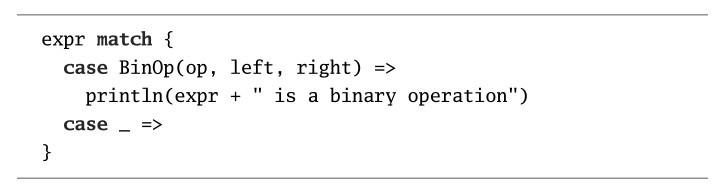
<center>示例15.3 带有空的“默认”样例的模式匹配</center>

In [17]:
def simplifyTop(expr: Expr): Unit = expr match {
    case BinOp(op, left, right) =>
        println(expr + " is a binary operation")
    case _ => 
}

defined function simplifyTop

## 15.2 模式的种类

前面的例子快速地展示了几种模式，接下来花些时间详细来介绍每一种。

模式的语法很容易理解，所以不必太担心。所有的模式跟相应的表达式看上去完全一样。例如，基于示例15.1的类层次结构，Var（x）这个模式将匹配任何变量表达式，并将x绑定成这个变量的名字。**作为表达式使用时**，Var（x）——完全相同的语法——将重新创建一个等效的对象，当然前提是x已经绑定到这个变量名。由于模式的语法是透明的，我们只需要关心能使用哪几种模式就对了。

### 通配模式

通配模式（\_）会匹配任何对象。前面已经看到过通配模式用于缺省、捕获所有的可选路径，就像这样：

In [18]:
def simplifyTop(expr: Expr): Unit = expr match {
    case BinOp(op, left, right) =>
        println(expr + " is a binary operation")
    case _ => //处理默认case
}

defined function simplifyTop

通配模式还可以用来忽略某个对象中你并不关心的局部。例如，前面这个例子实际上并不需要关心二元操作的操作元是什么，它只是检查这个表达式是否是二元操作，仅此而已。因此，这段代码也完全可以用通配模式来表示BinOp的操作元，参考示例15.4：

In [19]:
def checkbinary(expr: Expr) {
    expr match {
        case BinOp(op, left, right) =>
          println(expr + " is a binary operation")
        case _ =>
    }
}

defined function checkbinary

<center>示例15.4 带有通配模式的模式匹配</center>

### 常量模式

常量模式仅匹配自己。任何字面量都可以作为常量（模式）使用。例如，5、true和＂hello＂都是常量模式。同时，任何val或单例对象也可以被当作常量（模式）使用。例如，Nil这个单例对象能且仅能匹配空列表。示例15.5给出了常量模式的例子：

In [20]:
def describe(x: Any) = x match {
    case 5 => "five"
    case true => "truth"
    case "hello" => "hi!"
    case Nil => "the empty list"
    case _ => "something else"
}

defined function describe

<center>示例15.5 带有常量模式的模式匹配</center>

以下是示例15.5中的模式在具体使用场景中的效果：

In [21]:
describe(5)

res20: String = "five"

In [22]:
describe(true)

res21: String = "truth"

In [23]:
describe("hello")

res22: String = "hi!"

In [24]:
describe(Nil)

res23: String = "the empty list"

In [25]:
describe(List(1,2,3))

res24: String = "something else"

### 变量模式

变量模式匹配任何对象，这一点跟通配模式相同。**不过不同于通配模式的是，Scala将对应的变量绑定成匹配上的对象**。在绑定之后，你就可以用这个变量来对对象做进一步的处理。示例15.6给出了一个针对零的特例和针对所有其他值的缺省处理的模式匹配。缺省的case用到了变量模式，这样就给匹配的值赋予了一个名称，不论这个值是啥。

In [26]:
def startsWithZero(expr: Any) = {
    expr match {
        case 0 => "zero"
        case somethingElse => "not zero: " + somethingElse
    }
}

defined function startsWithZero

In [27]:
startsWithZero(0)

res26: String = "zero"

In [28]:
startsWithZero(231)

res27: String = "not zero: 231"

<center>示例15.6 带有变量模式的模式匹配</center>

#### 变量还是常量？

常量模式也可以有符号形式的名称。当我们把Nil当作一个模式的时候，实际上就是在用一个符号名称来引用常量。这里有一个相关的例子，这个模式匹配牵扯到常量E（2.71828...）和Pi（3.14159...）：

In [29]:
import math.{E, Pi}
E match {
    case Pi => "strange math? Pi = " + Pi
    case _ => "OK"
}

import math.{E, Pi}

res28_1: String = "OK"

跟我们预期的一样，E并不匹配Pi，因此“strange math”这个case没有被使用。

Scala编译器是如何知道Pi是从scala.math包引入的常量，而不是一个代表选择器值本身的变量呢？Scala采用了一个简单的词法规则来区分：**一个以小写字母打头的简单名称会被当作模式变量处理**；所有其他引用都是常量。想看到具体的区别？可以给Pi创建一个小写的别名，然后尝试如下代码：

In [30]:
val pi = math.Pi
E match {
    case pi => "strange math? Pi = " + pi
}

pi: Double = 3.141592653589793
res29_1: String = "strange math? Pi = 2.718281828459045"

在这里编译器甚至不允许我们添加一个默认的case。由于pi是变量模式，它将会匹配所有输入，因此不可能走到后面的case：

In [31]:
val pi = math.Pi
E match {
    case pi => "strange math? Pi = " + pi
    case _ => "OK"
}//并没有报warning

cmd30.sc:3: patterns after a variable pattern cannot match (SLS 8.1.1)
If you intended to match against value pi in class Helper, you must use backticks, like: case `pi` =>
    case pi => "strange math? Pi = " + pi
         ^cmd30.sc:4: unreachable code due to variable pattern 'pi' on line 3
    case _ => "OK"
              ^cmd30.sc:4: unreachable code
    case _ => "OK"
              ^

pi: Double = 3.141592653589793
res30_1: String = "strange math? Pi = 2.718281828459045"

如果需要，仍然可以用小写的名称来作为模式常量，有两个小技巧。首先，如果常量是某个对象的字段，可以在字段名前面加上限定词。例如，虽然pi是个变量模式，但this.pi或obj.pi是常量（模式），尽管它们以小写字母打头。如果这样不行（比如说pi可能是个局部变量），也可以用反引号将这个名称包起来。例如\`pi\`就能再次被编译器解读为一个常量，而不是变量了：

In [32]:
val pi = math.Pi
E match {
    case `pi` => "strange math? Pi = " + pi
    case _ => "OK"
}//并没有报warning

pi: Double = 3.141592653589793
res31_1: String = "OK"

**你应该看到了，给标识符加上反引号在Scala中有两种用途，来帮助你从不寻常的代码场景中走出来。这里你看到的是如何将小写字母打头的标识符用作模式匹配中的常量。更早的时候，在6.10节，你还看到过反引号可以用来将关键字当作普通的标识符，比如访问Java的Thread类的静态方法yield,Thread.\`yield\`（）这段代码将yield当作标识符而不是关键字。**

### 构造方法模式

构造方法模式是真正体现出模式匹配威力的地方。一个构造方法模式看上去像这样：“BinOp（＂+＂, e, Number（0））”。它由一个名称（BinOp）和一组圆括号中的模式：＂+＂、e和Number（0）组成。假定这里的名称指定的是一个样例类，这样的一个模式将首先检查被匹配的对象是否是以这个名称命名的样例类的实例，然后再检查这个对象的构造方法参数是否匹配这些额外给出的模式。

这些额外的模式意味着Scala的模式支持深度匹配（deep match）。这样的模式不仅检查给出的对象的顶层，还会进一步检查对象的内容是否匹配额外的模式要求。由于额外的模式也可能是构造方法模式，用它们来检查对象内部时可以到任意的深度。例如，示例15.7给出的模式将检查顶层的对象是BinOp，而它的第三个构造方法参数是一个Number，且这个Number的值字段为0。这是一个长度只有一行但深度有三层的模式。

层次结构：
> Binop
>> Number()
>>> 0

In [33]:
def deepmatch(expr: Expr) = {
    expr match {
      case BinOp("+", e, Number(0)) => println("a deep match")
      case _ => println("Nothing")
    }
}

defined function deepmatch

In [34]:
deepmatch(BinOp("+",Var("x"),Number(0)))

a deep match


In [35]:
deepmatch(BinOp("+",Var("x"),Number(1)))

Nothing


<center>示例15.7 带有构造方法模式的模式匹配</center>

### 序列模式

就跟与样例类匹配一样，也可以跟序列类型做匹配，比如List或Array。使用的语法是相同的，不过现在可以在模式中给出任意数量的元素。示例15.8显示了一个以0开始的三元素列表的模式。

In [36]:
def startsWithZero1(expr: List[Int]) = 
    expr match {
      case List(0, _, _) => println("found it")
      case _ =>
    }

defined function startsWithZero1

In [37]:
startsWithZero1(List(0,1,2))

found it


In [38]:
startsWithZero1(List(1,2,3))

<center>示例15.8 固定长度的序列模式</center>

如果你想匹配一个序列，但又不想给出多长，你可以用_\*作为模式的最后一个元素。这个看上去有些奇怪的模式能够匹配序列中任意数量的元素，包括0个元素。示例15.9显示了一个能匹配任意长度的以0开始的列表。

In [39]:
def startsWithZero2(expr: List[Int]) =
    expr match {
      case List(0, _*) => println("found it")
      case _ =>
    }

defined function startsWithZero2

In [40]:
startsWithZero2(List(0))

found it


In [41]:
startsWithZero2(List(0,1))

found it


In [42]:
startsWithZero2(List(2))

<center>示例15.9 任意长度的序列模式</center>

### 元组模式

我们还可以匹配元组（tuple）。形如（a, b, c）这样的模式能匹配任意的三元组。参考示例15.10。

In [43]:
def tupleDemo(expr: Any) =
    expr match {
        case(a,b,c) => println("matched " + a + b + c)
        case _ =>
    }

defined function tupleDemo

In [44]:
tupleDemo(("a",3,"-tuple"))

matched a3-tuple


In [45]:
tupleDemo((1))

### 带类型的模式

可以用带类型的模式（typed pattern）来替代类型测试和类型转换。参考示例15.11。

In [46]:
def generalSize(x: Any) = x match {
    case s: String => s.length
    case m: Map[_, _] => m.size
    case _ => -1
}

defined function generalSize

In [47]:
generalSize("abc")

res46: Int = 3

In [48]:
generalSize(Map(1->'a',2->'b'))

res47: Int = 2

In [49]:
generalSize(math.Pi)

res48: Int = -1

<center>示例15.11 带有类型模式的模式匹配</center>

generalSize方法返回不同类型的对象的大小或长度。其入参的类型是Any，因此可以是任何值。如果入参是String，那么方法将返回这个字符串的长度。模式“s:String”是一个带类型的模式，它将匹配每个（非null的）String实例。其中的模式变量s将指向这个字符串。

需要注意的是，尽管s和x指向同一个值，x的类型是Any，而s的类型是String。因此可以在与模式相对应的可选分支中使用s.length，但不能写成x.length，因为类型Any并没有一个叫作length的成员。

另一个跟用带类型的模式匹配等效但是更冗长的方式是做类型测试然后（强制）类型转换。对于类型测试和转换，Scala跟Java的语法不太一样。比方说要测试某个表达式expr的类型是否为String，我们需要这样写：

In [50]:
val expr = "abc"

expr: String = "abc"

In [51]:
expr.isInstanceOf[String]

res50: Boolean = true

In [52]:
expr.asInstanceOf[String]

res51: String = "abc"

通过类型测试和类型转换，可以重写示例15.12的match表达式。

In [53]:
def isInstance(expr: Any) = {
    if (
      expr.isInstanceOf[String]
    ) {
    val s = 
      expr.asInstanceOf[String]
      s.length
    } else 0
}

defined function isInstance

In [54]:
isInstance("abc")

res53: Int = 3

<center>示例15.12 使用isInstanceOf和asInstanceOf（不良风格）</center>

isInstanceOf和asInstanceOf两个操作符会被当作Any类的预定义方法处理，这两个方法接收一个用方括号括起来的类型参数。事实上，x.asInstanceOf[String]是该方法调用的一个特例，它带上了显式的类型参数String。

你现在应该已经注意到了，在Scala中编写类型测试和类型检查会比较啰唆。我们是有意为之，因为这并不是一个值得鼓励的做法。通常，使用带类型的模式会更好，尤其是当你需要同时做类型测试和类型转换的时候，因为这两个操作所做的事情会被并在单个模式匹配中完成。

示例15.11中的match表达式的第二个case包含了带类型的模式“m:Map[\_, \_]”。这个模式匹配的是任何Map值，不管它的键和值的类型是什么，然后让m指向这个值。因此，m.size的类型是完备的，返回的是这个映射 （map）的大小。类型模式（type pattern）[3]中的下画线就像是其他模式中的通配符。除了用下画线，你也可以用（小写的）类型变量。

### 类型擦除

除了笼统的映射，我们还能测试特定元素类型的映射吗？这对于测试某个值是否是Int到Int的映射这类场景会很方便。我们试试看吧：

In [55]:
def isIntIntMap(x: Any) = x match {
    case m: Map[Int, Int] => true
    case _ => false
}

cmd54.sc:2: non-variable type argument Int in type pattern scala.collection.immutable.Map[Int,Int] (the underlying of Map[Int,Int]) is unchecked since it is eliminated by erasure
    case m: Map[Int, Int] => true
            ^

defined function isIntIntMap

Scala采用了擦除式的泛型，就跟Java一样。这意味着在运行时并不会保留类型参数的信息。这么一来，我们在运行时就无法判断某个给定的Map对象是用两个Int的类型参数创建的，还是其他什么类型参数创建的。系统能做的只是判断某个值是某种不确定类型参数的Map。可以把isIntIntMap应用到不同的Map类实例来验证这个行为：

In [56]:
isIntIntMap(Map(1 -> -1))

res55: Boolean = true

In [57]:
isIntIntMap(Map("abc" -> "abc"))

res56: Boolean = true

第一次应用返回true，看上去是正确的，不过第二次应用同样返回true，这可能会让你感到意外。为了警示这种可能违反直觉的运行时行为，编译器会给出前面我们看到的那种非受检的警告。

对于这个擦除规则唯一的例外是数组，因为Java和Scala都对它们做了特殊处理。数组的元素类型是跟数组一起保存的，因此我们可以对它进行模式匹配。例如：

In [58]:
def isStringArray(x: Any) = x match {
    case a: Array[String] => "yes"
    case _ => "no"
}

defined function isStringArray

In [59]:
val as = Array("abc")

as: Array[String] = Array("abc")

In [60]:
isStringArray(as)

res59: String = "yes"

In [61]:
val ai = Array(1,2,3)

ai: Array[Int] = Array(1, 2, 3)

In [62]:
isStringArray(ai)

res61: String = "no"

### 变量绑定

除了独自存在的变量模式外，我们还可以对任何其他模式添加变量。只需要写下变量名、一个@符和模式本身，就得到一个变量绑定模式。意味着这个模式将跟平常一样执行模式匹配，如果匹配成功，就将匹配的对象赋值给这个变量，就像简单的变量模式一样。

示例15.13给出了一个（在表达式中）查找绝对值操作被连续应用两次的模式匹配的例子。这样的表达式可以被简化成只执行一次求绝对值的操作。

In [63]:
def matchUnOp(expr: Expr) = {
    expr match {
      case UnOp("abs", e @ UnOp("abs", _)) => e
      //case UnOp("abs", e @ _) => e
      case _ =>
    }
}

defined function matchUnOp

In [64]:
val unopExpr = new UnOp("abs", new Number(3))
matchUnOp(unopExpr)
matchUnOp(new UnOp("abs", unopExpr))

unopExpr: UnOp = UnOp("abs", Number(3.0))
res63_1: Any = ()
res63_2: Any = UnOp("abs", Number(3.0))

示例15.13包括了一个以e为变量，UnOp（＂abs＂, \_）为模式的的变量绑定模式。如果整个匹配成功了，那么匹配了UnOp（＂abs＂, \_）的部分就被赋值给变量e。这个case的结果就是e，这是因为e跟expr的值相同，但是少了一次求绝对值的操作。

## 15.3 模式守卫

有时候语法级的模式匹配不够精准。举例来说，假定我们要公式化一个简化规则，即用乘以2（e * 2）来替换对两个相同操作元的加法（e + e）。在表示Expr树的语言中，下面这样的表达式：
```scala
def simplifyAdd(e: Expr) = e match {
    case BinOp("+", x, x) => BinOp("*", x, Number(2))
    case _ => e
}

```
```
cmd64.sc:2: x is already defined as value x
    case BinOp("+", x, x) => BinOp("*", x, Number(2))
                       ^Compilation Failed

Compilation Failed
```

这样做会失败，**因为Scala要求模式都是线性（linear）的：同一个模式变量在模式中只能出现一次**。不过，我们可以用一个模式守卫（pattern guard）来重新定义这个匹配逻辑，如示例15.14所示：

In [65]:
def simplifyAdd(e: Expr) = e match {
    case BinOp("+", x, y) if x == y => BinOp("*", x, Number(2))
    case _ => e
}

defined function simplifyAdd

<center>示例15.14 带有模式守卫的match表达式</center>

模式守卫出现在模式之后，并以if打头。模式守卫可以是任意的布尔表达式，通常会引用到模式中的变量。如果存在模式守卫，这个匹配仅在模式守卫求值得到true时才会成功。因此，上面提到的首个case只能匹配那些两个操作元相等的二元操作。

以下是其他一些带有守卫的模式示例：
```scala
// match only positive integers
case n: Int if 0 < n => ...  

// match only strings starting with the letter `a'
case s: String if s(0) == 'a' => ... 
```

## 15.4 模式重叠

模式会按照代码中的顺序逐个被尝试。示例15.15中的simplify展示了模式中的case出现顺序的重要性。

In [66]:
def simplifyAll(expr: Expr): Expr = expr match {
    case UnOp("-", UnOp("-", e)) =>
      simplifyAll(e)   // `-' is its own inverse
    case BinOp("+", e, Number(0)) =>
      simplifyAll(e)   // `0' is a neutral element for `+'
    case BinOp("*", e, Number(1)) =>
      simplifyAll(e)   // `1' is a neutral element for `*'
    case UnOp(op, e) => 
      UnOp(op, simplifyAll(e))
    case BinOp(op, l, r) =>
      BinOp(op, simplifyAll(l), simplifyAll(r))
    case _ => expr
}

defined function simplifyAll

示例15.15中的simplify将会对一个表达式中的各处都执行简化，不像simplifyTop那样仅仅在顶层做简化。simplify可以从 simplifyTop演化出来，只需要再添加两个case分别针对一元和二元表达式即可（示例15.15中的第四和第五个case）。

第四个case的模式是UnOp（op, e），它匹配所有的一元操作。这个一元操作的操作符和操作元可以是任意的。它们分别被绑定到模式变量op和e上。这个case对应的可选分支会递归地对操 作元e应用simplifyAll，然后用（可能的）简化后的操作元重建这个一元操作。第五个B i n O p的case也是同理：它是一个“捕获所有”（catch-all）的对任意二元操作的匹配，匹配成功后递归地对它的两个操作元应用简化方法。

在本例中，捕获所有的case出现在更具体的简化规则之后，这是很重要的。如果我们将顺序颠倒过来，那么捕获所有的case就会优先于更具体的规则执行。在 许多场景下，编译器甚至会拒绝编译。例如下面这个match表达式就无法通过编译，因为首个case将会匹配所有第二个case能匹配的值：

In [67]:
def simplifyBad(expr: Expr): Expr = expr match {
    case UnOp(op, e) => UnOp(op, simplifyBad(e))
    case UnOp("-", UnOp("-", e)) => e
}

cmd66.sc:3: unreachable code
    case UnOp("-", UnOp("-", e)) => e
                                    ^

defined function simplifyBad

## 15.5 密封类

每当我们编写一个模式匹配时，都需要确保完整地覆盖了所有可能的case。有时候可以通过在末尾添加一个缺省case来做到，不过这仅限于有合理兜底的场合。如果没有这样的缺省行为，我们如何确信自己覆盖了所有的场景呢？

我们可以寻求Scala编译器的帮助，帮我们检测出match表达式中缺失的模式组合。为了做到这一点，编译器需要分辨出可能的case有哪些。一般来说，在Scala中这是不可能的，因为新的样例类随时随地都能被定义出来。例如没有人会阻止你在现在的四个样例类所在的编译单元之外的另一个编译单元中给 Expr的类继承关系添加第五个样例类。

解决这个问题的手段是将这些样例类的超类标记为密封（sealed）的。**密封类除了在同一个文件中定义的子类之外，不能添加新的子类**。这一点对于模式匹配而言十分有用，因为这样一来我们就只需要关心那些已知的样例类。不仅如此，我们还因此获得了更好的编译器支持。**如果我们对继承自密封类的样例类做匹配，编译器会用警告消息标示出缺失的模式组合**。

如果你的类打算被用于模式匹配，那么你应该考虑将它们做成密封类。只需要在类继承关系的顶部那个类的类名前面加上sealed关键字。这样，使用你的这组类的程序员在模式匹配你的这些类时，就会信心十足。 这也是为什么sealed关键字通常被看作模式匹配的执照的原因。示例15.16给出了Expr被转成密封类的例子。

In [68]:
sealed abstract class Expr
case class Var(name: String) extends Expr
case class Number(num: Double) extends Expr
case class UnOp(operator: String, arg: Expr) extends Expr
case class BinOp(operator: String, 
  left: Expr, right: Expr) extends Expr

defined class Expr
defined class Var
defined class Number
defined class UnOp
defined class BinOp

<center>示例15.16 一组继承关系封闭的样例类</center>

现在我们可以试着定义一个漏掉了某些可能case的模式匹配：

In [69]:
def describe(e: Expr): String = e match {
    case Number(_) => "a number"
    case Var(_) => "a variable"
}

cmd68.sc:1: match may not be exhaustive.
It would fail on the following inputs: BinOp(_, _, _), UnOp(_, _)
def describe(e: Expr): String = e match {
                                ^

defined function describe

这样的警告告诉我们这段代码存在产生MatchError异常的风险，因为某些可能出现的模式（UnOp、BinOp）并没有被处理。这个警告指出了潜在的运行时错误源，因此这通常有助于我们编写正确的程序。

不过，有时候你也会遇到编译器过于挑剔的情况。举例来说，你可能从上下文知道你永远只会将describe应用到Number或Var，因此你很清楚不会有MatchError发生。这时你可以对describe添加一个捕获所有的case，这样就不会有编译器告警了：

In [70]:
def describe(e: Expr): String = e match {
    case Number(_) => "a number"
    case Var(_) => "a variable"
    case _ => throw new RuntimeException //不应该发生
}

defined function describe

这样可行，但并不理想。你可能并不会很乐意，因为你被迫添加了永远不会被执行的代码（也可能是你认为不会），而所有这些只是为了让编译器闭嘴。

一个更轻量的做法是给match表达式的选择器部分添加一个@unchecked注解。就像这样：

In [71]:
def describe(e: Expr): String = (e: @unchecked) match {
    case Number(_) => "a number"
    case Var(_) => "a variable"
}

defined function describe

我们会在第27章介绍注解。一般来说，可以像添加类型声明那样对表达式添加注解：在表达式后加一个冒号和注解的名称（以@打头）。例如，在本例中我们给变量 e添加了@unchecked注解，即“e: @unchecked”。@unchecked注解对模式匹配而言有特殊的含义。如果match表达式的选择器带上了这个注解，那么编译器对后续模式分支的覆盖完整性检查就会被压制。
## 15.6 Option类型

Scala由一个名为Option的标准类型来表示可选值。这样的值可以有两种形式：Some（x），其中x是那个实际的值；或者None对象，代表没有值。

Scala集合类的某些标准操作会返回可选值。比如，Scala的Map有一个get方法，当传入的键有对应的值时，返回Some（value）；而当传入的键在Map中没有定义时，返回None。我们来看下面这个例子：

In [72]:
val capitals = Map("France" -> "Paris", "Japan" -> "Tokyo")

capitals: Map[String, String] = Map("France" -> "Paris", "Japan" -> "Tokyo")

In [73]:
capitals get "France"

res72: Option[String] = Some("Paris")

In [74]:
capitals get "North Pole"

res73: Option[String] = None

将可选值解开最常见的方式是通过模式匹配。例如：

In [75]:
def show(x: Option[String]) = x match{
    case Some(s) => s
    case None => "?"
}

defined function show

In [76]:
show(capitals get "France")

res75: String = "Paris"

In [77]:
show(capitals get "North Pole")

res76: String = "?"

Scala程序经常用到Option类型。可以把这个跟Java中用null来表示无值做比较。举例来说，java.util.HashMap的get方法要么返回存放在HashMap中的某个值，要么（在值未找到时）返回null。这种方式对Java来说是可以的，但很容易出错，因为在实践当中要想跟踪某个程序中的哪些变量可以为null是一件很困难的事。

如果某个变量允许为null，那么必须记住在每次用到它的时候都要判空（null）。如果忘记了，那么运行时就有可能出现NullPointerException。由于这样的类异常可能并不经常发生，在测试过程中也就很难发现。对Scala而言，这种方式完全不能工作，因为Scala允许在哈希映射中存放值类型的数据，而null并不是值类型的合法元素。例如，一个HashMap[Int, Int]不可能用返回null来表示“无值”。

Scala鼓励我们使用Option来表示可选值。这种处理可选值的方式跟Java相比有若干优势。首先，对于代码的读者而言，某个类型为 Option[String]的变量对应一个可选的String，跟某个类型为String的变量是一个可选的String（可能为null）相比，要直 观得多。不过最重要的是，我们之前描述的那种在不检查某个变量是否为null就开始用它的编程错误在Scala中直接变成了类型错误。如果某个变量的类型为Option[String]，而我们把它当作String来用，这样的 Scala程序是无法编译通过的。
## 15.7 到处都是模式

Scala中很多地方都允许使用模式，并不仅仅是match表达式。我们来看看其他能用模式的地方。

### 变量定义中的模式

每当我们定义一个val或var，都可以用模式而不是简单的标识符。例如，可以将一个元组解开并将其中的每个元素分别赋值给不同的变量，参考示例15.17：

In [78]:
val myTuple = (123, "abc")

myTuple: (Int, String) = (123, "abc")

In [79]:
val (number, string) = myTuple

number: Int = 123
string: String = "abc"

<center>示例15.17 用单个赋值定义多个变量</center>

这个语法结构在处理样例类时非常有用。如果你知道要处理的样例类是什么，就可以用一个模式来析构它。参考下面的例子：

In [80]:
val exp = new BinOp("*", Number(5), Number(1))

exp: BinOp = BinOp("*", Number(5.0), Number(1.0))

In [81]:
val BinOp(op, left, right) = exp

op: String = "*"
left: Expr = Number(5.0)
right: Expr = Number(1.0)

### 作为偏函数的case序列

用花括号包起来的一系列case（即可选分支）可以用在任何允许出现函数字面量的地方。**本质上讲，case序列就是一个函数字面量，只是更加通用**。不像普通函数那样只有一个入口和参数列表，case序列可以有多个入口，每个入口都有自己的参数列表。每个case对应该函数的一个入口，而该入口的参数列表用模式来指定。每个入口的逻辑主体是case右边的部分。

下面是个简单的例子：

In [82]:
val withDefault: Option[Int] => Int = {
    case Some(x) => x
    case None => 0
}

withDefault: Option[Int] => Int = ammonite.$sess.cmd81$Helper$$Lambda$2781/2039026628@60f72413

该函数的函数体有两个case。第一个case匹配Some，返回Some中的值。第二个case匹配None，返回默认值0。以下是这个函数用起来的效果：

In [83]:
withDefault(Some(10))

res82: Int = 10

In [84]:
withDefault(None)

res83: Int = 0

这套机制对于Akka这个actor类库而言十分有用，因为有了它，Akka可以用一组case来定义它的receive方法：
```scala
var sum = 0

def receive = {

  case Data(byte) =>
    sum += byte

  case GetChecksum(requester) =>
    val checksum = ~(sum & 0xFF) + 1
    requester ! checksum
}
```

还有另一点值得我们注意：通过case序列得到的是一个偏函数（partial function）。如果我们将这样一个函数应用到它不支持的值上，它会产生一个运行时异常。例如，这里有一个返回整数列表中第二个元素的偏函数：

In [85]:
val second: List[Int] => Int = {
    case x::y::_ => y
}

cmd84.sc:1: match may not be exhaustive.
It would fail on the following inputs: List(_), Nil
val second: List[Int] => Int = {
                               ^

second: List[Int] => Int = ammonite.$sess.cmd84$Helper$$Lambda$2794/523696634@499e8899

In [86]:
second(List(6,7,8))

res85: Int = 7

In [86]:
//second(List())

如果你想检查某个偏函数是否对某个入参有定义，必须首先告诉编译器你知道你要处理的是偏函数。List[Int] => Int这个类型涵盖了所有从整数列表到整数的函数，不论这个函数是偏函数还是全函数。仅涵盖从整数列表到整数的偏函数的类型写作 PartialFunction[List[Int], Int]。我们重新写一遍second函数，这次用偏函数的类型声明：

In [87]:
val second: PartialFunction[List[Int],Int] = {
    case x::y::_ => y
}

second: PartialFunction[List[Int], Int] = <function1>

偏函数定义了一个isDefinedAt方法，可以用来检查该函数是否对某个特定的值有定义。在本例中，这个函数对于任何至少有两个元素的列表都有定义：

In [88]:
second.isDefinedAt(List(5,6,7))

res87: Boolean = true

In [89]:
second.isDefinedAt(List(5,6,7,8))

res88: Boolean = true

In [90]:
second.isDefinedAt(List(5,6))

res89: Boolean = true

In [91]:
second.isDefinedAt(List(5))

res90: Boolean = false

In [92]:
second.isDefinedAt(List())

res91: Boolean = false

偏函数的典型用例是模式匹配函数字面量，就像前面这个例子。事实上，这样的表达式会被Scala编译器翻译成偏函数，这样的翻译发生了两次：一次是实现真正的函数，另一次是测试这个函数是否对指定值有定义。

举例来说，函数字面量{ case x::y::_ => y }将被翻译成如下的偏函数值：

In [93]:
new PartialFunction[List[Int],Int] {
    def apply(xs: List[Int]) = xs match {
        case x::y::_ => y
    }
    def isDefinedAt(xs: List[Int]) = xs match {
        case x::y::_ => true
        case _ => false
    }
}

cmd92.sc:2: match may not be exhaustive.
It would fail on the following inputs: List(_), Nil
    def apply(xs: List[Int]) = xs match {
                               ^

res92: AnyRef with PartialFunction[List[Int], Int] = <function1>

只要函数字面量声明的类型是PartialFunction，这样的翻译就会生效。如果声明的类型只是Function1，或没有声明，那么函数字面量对应的就是一个全函数（complete function）。

一般来说，我们应该尽量用全函数，因为偏函数允许运行时出现错误，而编译器帮不了我们。不过有时候偏函数也特别有用。你也许能确信不会有不能处理的值传入， 也可能会用到那种预期偏函数的框架，在调用函数之前，总是会先用isDefinedAt做一次检查。后者的例子可以参考上面讲到的react示例，示例中的入参是一个偏函数，只处理那些调用方想处理的消息。[4]

### for表达式中的模式

我们还可以在for表达式中使用模式，如示例15.18。这里的for表达式从capitals映射中接收键/值对，每个键/值对都跟模式（country, city）匹配，这个模式定义了两个变量，country和city。

In [94]:
val capitals = Map("France" -> "Paris", "Japan" -> "Tokyo")
for((country, city) <- capitals)
    println("The capital of " + country + " is " + city)

The capital of France is Paris
The capital of Japan is Tokyo


capitals: Map[String, String] = Map("France" -> "Paris", "Japan" -> "Tokyo")

<center>示例15.18 带有元组模式的for表达式</center>

示例15.18给出的对偶（pair）模式很特别，因为这个匹配永远都不会失败。的确，capitals交出一系列的对偶，因此可以确信每个生成的对偶都能够跟对偶模式匹配上。

不过某个模式不能匹配某个生成的值的情况也同样存在。示例15.19的代码就是这样一个例子。

In [95]:
val results = List(Some("apple"), None, Some("orange"))
for(Some(fruit) <- results) println(fruit)

apple
orange


results: List[Option[String]] = List(Some("apple"), None, Some("orange"))

<center>示例15.19 从列表中选取匹配特定模式的元素</center>

我们从这个例子当中可以看到，**生成的值当中那些不能匹配给定模式的值会被直接丢弃**。例如，results列表中的第二个元素None就不能匹配上模式Some（fruit），因此它也就不会出现在输出当中了。
## 15.8 一个复杂的例子

在学习了模式的不同形式之后，你可能会对它们在相对复杂的例子中是如何应用的感兴趣。提议的任务是编写一个表达式格式化类，以二维布局来显示一个算术表达式。诸如“x / （x + 1）”的除法应该纵向打印，将被除数放在除数上面，就像这样：
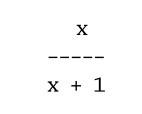

再看另一个例子，表达式（（a / （b * c） + 1 / n） / 3）放在二维布局是这样的：
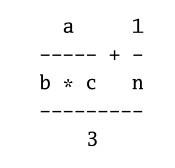

从这些示例来看，要定义的这个类（我们就叫它ExprFormatter吧）需要做大量的布局安排，因此我们有理由使用在第10章开发的布局类库。我们还会 用到本章前面讲到的Expr这组样例类，并将第10章的布局类库和本章的表达式格式化工具放在对应名称的包里。这个例子的完整代码请参考示例15.20和 示例15.21。

第一步，我们先集中精力做好横向布局。比如对于下面这个结构化的表达式：
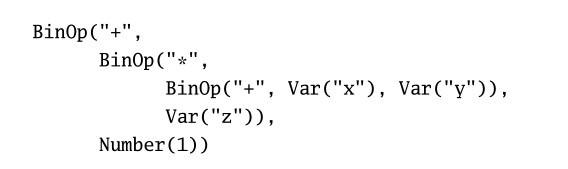

应该打印出 （x + y） * z + 1。注意包在x + y外围的这组圆括号是必需的，但（x + y） * z外围则不是必需的。为了保持布局尽可能清晰易读，我们的目标是去掉冗余的圆括号，同时确保所有必要的圆括号继续保留。

为了知道哪里该放置圆括号，我们的代码需要知晓操作符的优先级，我们先把这件事搞定吧。可以用下面这样的映射字面量来直接表示优先级：
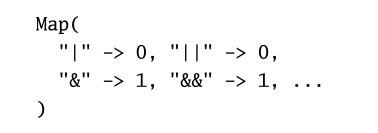

不过，这需要我们自己来事先做一些运算。更方便的做法是按照递增的优先级定义多组操作符，然后再从中计算每个操作符的优先级。具体代码参考示例15.20。

变量precedence是一个从操作符到优先级的映射，其中优先级从0开始。它是通过一个带有两个生成器的for表达式计算出来的。第一个生成器产生 opGroups数组的每一个下标i，第二个生成器产生opGroups（i）中的每一个操作符op。对每一个操作符，for表达式都会交出这个操作符 op到下标i的关联。这样一来，数组中操作符的相对位置就被当作它的优先级。

关联关系用中缀的剪头表示，例如op -> i。之前我们只在映射的构造过程中看到过这样的关联，不过它们本身也是一种值。事实上，op -> i这样的关联跟对偶（op, i）是一回事。

现在我们已经搞定了所有除/之外的二元操作符的优先级，接下来我们将这个概念进一步泛化让它也包含一元操作符。一元操作符的优先级高于所有的二元操作符。因此可以将unaryPrecedence（示例15.20）的优先级设为跟opGroups的长度相等，也就是比\*和%操作符多1。分数的优先级处理区别 于其他操作符，因为分数采用的是纵向布局。不过，稍后我们就会看到，将除法的优先级设置为特殊的-1会很方便，因此我们将 fractionPrecedence设为-1（如示例15.20所示）。

完成了这些准备工作之后，我们就可以着手编写format这个主方法了。该方法接收两个入参：类型为Expr的表达式e和直接闭合表达式e的的操作符的优先级encPrec（如果没有直接闭合的操作符，enclPrec应设为0）。这个方法交出的是一个代表了二维字符数组的布局元素。

示例15.20表达式格式化方法的上半部分

示例15.21给出了ExprFormatter类的余下部分，包含三个方法。第一个方法stripDot是一个助手方法；第二个私有的format方法完 成了格式化表达式的主要工作；最后一个同样命名为format的方法是类库中唯一的公开方法，接收一个要格式化的表达式作为入参。私有的format方法 通过对表达式的种类执行模式匹配来完成工作。这里的match表达式有五个case，我们将逐一介绍每个case。

In [96]:
  class ExprFormatter {
  
    // Contains operators in groups of increasing precedence
    private val opGroups =
      Array(
        Set("|", "||"),
        Set("&", "&&"),
        Set("^"),
        Set("==", "!="),
        Set("<", "<=", ">", ">="),
        Set("+", "-"),
        Set("*", "%")
      )
  
    // A mapping from operators to their precedence
    private val precedence = {
      val assocs =
        for {
          i <- 0 until opGroups.length
          op <- opGroups(i)
        } yield op -> i
      assocs.toMap
    }
  
    private val unaryPrecedence = opGroups.length
    private val fractionPrecedence = -1
  
    // continued in Listing 15.21...

  //import org.stairwaybook.layout.Element

  // ...continued from Listing 15.20
  
  //import org.stairwaybook.layout.Element
  
  private def format(e: Expr, enclPrec: Int): Element =
  
    e match {
      //如果表达式是一个变量，结果就是由该变量名构成的元素。
      case Var(name) => 
        elem(name)
        
      //如果表达式是一个数值，结果就是一个由该数值构成的元素。
      //stripDot函数通过去掉＂.0＂后缀来简化显示浮点数。
      case Number(num) => 
        def stripDot(s: String) = 
          if (s endsWith ".0") s.substring(0, s.length - 2)
          else s
        elem(stripDot(num.toString))
      
      //如果表达式是一个一元操作UnOp（op, arg），
      //结果就是由操作op和用当前环境中最高优先级格式化入参arg后的结果构成。
      //[5]这意味着如果arg是二元操作符（不过不是分数），它将总是显示在圆括号中。
      case UnOp(op, arg) => 
        elem(op) beside format(arg, unaryPrecedence)
  
      //如果表达式是一个分数，那么中间结果frac就是由格式化后的操作元left和right上下叠在一起用横线隔开构成的。
      //横线的宽度是被格式化的操作元宽度 的最大值。
      //这个中间结果也就是最终结果，除非这个分数本身是另一个分数的入参。
      //对于后面这种情况，在frac的两边都会添加一个空格。
      //要搞清楚为什么需要 这样做，考虑表达式“（a / b） / c”。
      case BinOp("/", left, right) => 
        val top = format(left, fractionPrecedence)
        val bot = format(right, fractionPrecedence)
        val line = elem('-', top.width max bot.width, 1)
        val frac = top above line above bot
        if (enclPrec != fractionPrecedence) frac
        else elem(" ") beside frac beside elem(" ")
  
      case BinOp(op, left, right) => 
        val opPrec = precedence(op)
        val l = format(left, opPrec) 
        val r = format(right, opPrec + 1)
        val oper = l beside elem(" " + op + " ") beside r 
        if (enclPrec <= opPrec) oper
        else elem("(") beside oper beside elem(")")
    }
  
    def format(e: Expr): Element = format(e, 0)
  }

defined class ExprFormatter

第一个case是：
```scala
case Var(name) => elem(name)
```
如果表达式是一个变量，结果就是由该变量名构成的元素。

第二个case是：
```scala
case Number(num) => 
    def stripDot(s: String) = 
        if (s endsWith ".0") s.substring(0, s.length - 2)
        else s
    elem(stripDot(num.toString))
```
如果表达式是一个数值，结果就是一个由该数值构成的元素。stripDot函数通过去掉＂.0＂后缀来简化显示浮点数。

第三个case是：
```scala
case UnOp(op, arg) => 
    elem(op) beside format(arg, unaryPrecedence)
```
如果表达式是一个一元操作UnOp（op, arg），结果就是由操作op和用当前环境中最高优先级格式化入参arg后的结果构成。[5]这意味着如果arg是二元操作符（不过不是分数），它将总是显示在圆括号中。

第四个case是：
```scala
case BinOp("/", left, right) => 
    val top = format(left, fractionPrecedence)
    val bot = format(right, fractionPrecedence)
    val line = elem('-', top.width max bot.width, 1)
    val frac = top above line above bot
    if (enclPrec != fractionPrecedence) frac
    else elem(" ") beside frac beside elem(" ")
```
如果表达式是一个分数，那么中间结果frac就是由格式化后的操作元left和right上下叠在一起用横线隔开构成的。横线的宽度是被格式化的操作元宽度 的最大值。这个中间结果也就是最终结果，除非这个分数本身是另一个分数的入参。对于后面这种情况，在frac的两边都会添加一个空格。要搞清楚为什么需要 这样做，考虑表达式“（a / b） / c”。

如果没有这样的加宽处理，这个表达式在格式化之后的效果会是这样的：  
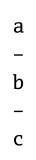

这个布局的问题很明显：到底哪一条横线表示了分数的第一级是不清楚的。上述表达式既可以被解读为“（a / b） / c”也可以被解读为“a / （b / c）”。为了清晰地表示出是哪一种先后次序，需要给内嵌的分数“a / b”在布局的两边加上空格。

这样一来，布局就没有歧义了：  
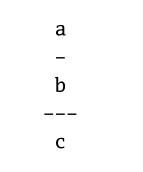

第五个也就是最后一个case是：
```scala
case BinOp(op, left, right) => 
    val opPrec = precedence(op)
    val l = format(left, opPrec) 
    val r = format(right, opPrec + 1)
    val oper = l beside elem(" " + op + " ") beside r 
    if (enclPrec <= opPrec) oper
    else elem("(") beside oper beside elem(")")
```
这个case作用于所有其他二元操作。由于它出现在下面这个case之后：
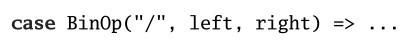

我们知道模式BinOp（op, left, right）中的op不可能是一个除法。要格式化这样一个二元操作，需要首先将其操作元left和right格式化。格式化左操作元的优先级参数是操作符op的opPrec，而格式化右操作元的优先级比它要多1。这样的机制确保了圆括号能够正确反映结合性（associativity）。

例如，如下操作：
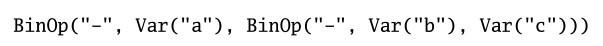

将被正确地加上圆括号：“a - （b - c）”。中间结果oper由格式化后的左操作元和格式化后的右操作元并排放在一起用操作符隔开构成。如果当前操作符的优先级比闭合该操作的操作符（即上一层操作符）小，那么oper就被放在圆括号当中；否则就直接返回。

这样我们就完成了私有format函数的设计。只剩下公开的format方法，调用方可以通过该方法格式化的一个顶级表达式，而不需要传入优先级入参。示例15.22给出了一个使用ExprFormatter的演示程序。

In [97]:
//import org.stairwaybook.layout.Element
//import Element.elem


//import org.stairwaybook.expr._


  val f = new ExprFormatter

  val e1 = BinOp("*", BinOp("/", Number(1), Number(2)), 
                      BinOp("+", Var("x"), Number(1)))

  val e2 = BinOp("+", BinOp("/", Var("x"), Number(2)), 
                      BinOp("/", Number(1.5), Var("x")))

  val e3 = BinOp("/", e1, e2)

  def show(e: Expr) = println(f.format(e)+ "\n\n")

  for (e <- Array(e1, e2, e3)) show(e)

1          
- * (x + 1)
2          


x   1.5
- + ---
2    x 


1          
- * (x + 1)
2          
-----------
  x   1.5  
  - + ---  
  2    x   




f: ExprFormatter = ammonite.$sess.cmd95$Helper$ExprFormatter@28e51668
e1: BinOp = BinOp(
  "*",
  BinOp("/", Number(1.0), Number(2.0)),
  BinOp("+", Var("x"), Number(1.0))
)
e2: BinOp = BinOp(
  "+",
  BinOp("/", Var("x"), Number(2.0)),
  BinOp("/", Number(1.5), Var("x"))
)
e3: BinOp = BinOp(
  "/",
  BinOp(
    "*",
    BinOp("/", Number(1.0), Number(2.0)),
    BinOp("+", Var("x"), Number(1.0))
  ),
  BinOp(
    "+",
    BinOp("/", Var("x"), Number(2.0)),
    BinOp("/", Number(1.5), Var("x"))
  )
)
defined function show

## 15.9 结语

在 本章，你详细地了解了Scala的样例类和模式匹配。通过它们，可以利用一些通常在面向对象编程语言中没有的精简写法。不过，本章描述的内容并不是 Scala的模式匹配的全部。假如你想对你的类做模式匹配，但又不想像样例类那样将你的类开放给其他人访问，可以用第26章介绍的提取器（extractor）。在下一章，我们将注意力转向列表。

[1].除了用抽象类外，我们还可以选择用特质来对这个类层次结构的根建模。（不过）用抽象类可能会稍微高效一些。

[2].Gamma,et al.,《Design Patterns》[Gam95]

[3].在m: Map[_, _]这个带类型的模式中，“Map[_, _]”的部分称为类型模式（type pattern）。

[4].原书这里的表述有些问题，react实际上指的是Akka的receive方法，而Akka严格来说并不是一个框架，而是类库，只是从代码局部来看跟框架的效果相似而已。——译者注

[5].unaryPrecedence是最高优先级，因为它被初始化成比*和%多1。